<h1 align='center'>Prediction on Readmission Rates</h1> <a id=100></a>

1. [Introduction](#1) <a id=18></a>
    - 1.1 [Data Dictionary](#2)
    - 1.2 [Task](#3)
2. [Preparation](#4)
    - 2.1 [Packages and Data](#5)
    - 2.2 [Preliminary Analysis and the Final Dataset](#6)
3. [Exploratory Data Analysis (EDA)](#7)
    - 3.1 [Univariate Analysis](#9)
    - 3.2 [Bivariate Analysis](#10)
4. [Data Preprocessing](#11)
    - 4.1 [Conclusions from the EDA](#12)
    - 4.2 [Packages](#13)
    - 4.3 [Making features model ready](#14)
5. [Modeling](#15)
    - 5.1 [Linear Classifiers](#16)
    - 5.2 [Tree Models](#17)

### Introduction <a id=1></a>
[back to top](#100)

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.

(1) It is an inpatient encounter (a hospital admission).

(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.

(3) The length of stay was at least 1 day and at most 14 days.

(4) Laboratory tests were performed during the encounter.

(5) Medications were administered during the encounter.

The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

#### 1.1 Data Dictionary <a id=2></a>
`encounter_id` - Unique identifier of an encounter

`patient_nbr` - Unique identifier of a patient

`race` - Values: Caucasian, Asian, African American, Hispanic, and other

`gender` - Values: male, female, and unknown/invalid

`age` - Grouped in 10-year intervals: [0,10), [10,20), …, [90,100)

`weight` - Weight in pounds.

`admission_type_id` - Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available	

`discharge_disposition_id`  - Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available	

`admission_source_id` - Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

`time_in_hospital` - Integer number of days between admission and discharge (1~14)

`payer_code` - Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay	

`medical_specialty` - Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon

`num_lab_procedures` - Number of lab tests performed during the encounter	

`num_procedures` - Number of procedures (other than lab tests) performed during the encounter

`num_medications` - Number of distinct generic names administered during the encounter

`number_outpatient` - Number of outpatient visits of the patient in the year preceding the encounter	

`number_emergency` - Number of emergency visits of the patient in the year preceding the encounter	

`number_inpatient` - Number of inpatient visits of the patient in the year preceding the encounter	

`diag_1` - The primary diagnosis (coded as first three digits of ICD9); 848 distinct values	

`diag_2` - Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values	

`diag_3` - Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values	

`number_diagnoses` - Number of diagnoses entered to the system	

`max_glu_serum` - Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured	

`A1Cresult` - Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.	

23 features for medications -

`metformin`, 
`repaglinide`, `nateglinide`, `chlorpropamide`,
`glimepiride`, `acetohexamide`, `glipizide`, `glyburide`, `tolbutamide`, `pioglitazone`,
`rosiglitazone`, `acarbose`, `miglitol`, `troglitazone`, `tolazamide`, `examide`, `sitagliptin`, `insulin`,
`glyburide-metformin`, `glipizide-metformin`, `glimepiride-pioglitazone`,
`metformin-rosiglitazone`, `metformin-pioglitazone`, the feature indicates whether
the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage
was increased during the encounter, “down” if the dosage was decreased, “steady” if the
dosage did not change, and “no” if the drug was not prescribed


`change` - Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”

`diabetesMed` - Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”	

`readmitted` - Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission.	


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### 2. Preparation <a id=4></a>
[back to top](#100)

#### 2.1 Import Packages and Load Data <a id=5></a>

In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


In [3]:
# load datasets
df = pd.read_csv("/Users/kaiwenliu/Documents/Communication Requirement/diabete/dataset_diabetes/diabetic_data.csv")
name_map = pd.read_csv("/Users/kaiwenliu/Documents/Communication Requirement/diabete/dataset_diabetes/IDs_mapping.csv")


X = df.drop(columns=['readmitted']) #  features
y = df['readmitted'] #  target variable

In [4]:
y.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [5]:
# Since we are only interested in whether patients are readmitted within 30 days or not
# we will group '>30' and 'No' to 'other' group
y_binary = np.where(np.not_equal(y, '<30'), 'other', y)

# Convert the categorical target variable into numeric format
le = LabelEncoder()
y_encoded = le.fit_transform(y_binary)
print(le.classes_)

['<30' 'other']


In [6]:
# # find the indices where the blank lines are located
# blank_line_indices = name_map.index[name_map.isnull().all(1)]

# # split the DataFrame into three separate DataFrames
# admission_type_id_map = name_map.iloc[:blank_line_indices[0]]
# discharge_disposition_id_map = name_map.iloc[blank_line_indices[0]+1:blank_line_indices[1]]
# dfadmission_source_id3 = name_map.iloc[blank_line_indices[1]+1:]

#### 2.2 Final dataset

##### 2.2.1 Drop dependent observations

In [7]:
# create an operation to drop certain ovservationsa
class DropObservations(BaseEstimator, TransformerMixin):
    def __init__(self):
        # id to remove for redundancy
        self.id_remove = []
        # id to remove for certain values in discharge_disposition_id        
        self.id_remove_dd = []
        self.rmPool = set([11,13,14,19,20,26])
     
    def update_drop_list(self,X):
        # We thus used only one encounter per patient; in particular, 
        # we considered only the first encounter for each patient as the primary admission and 
        # determined whether or not they were readmitted within 30 days. 

        patient_id_pool = set()
        for ind, val in X['patient_nbr'].items():
            if val in patient_id_pool:
                self.id_remove.append(ind)
            else:
                patient_id_pool.add(val)
        
        # Additionally, we removed all encounters that resulted in either discharge to a hospice 
        # (corresponeds to discharge_disposition_id=[13,14,19,20,26]) or 
        # patient death (correspondes to discharge_disposition_id=11), 
        # to avoid biasing our analysis.
        
        for i,v in X['discharge_disposition_id'].items():
            if v in self.rmPool:
                self.id_remove_dd.append(i)
                        
    def fit_transform(self, X, y):
        X_new = X.reset_index(drop=True)
        y_new = pd.Series(y)
        self.update_drop_list(X_new)
        # drop rows according to the ids and return
        ind_drop = self.id_remove+self.id_remove_dd
        return [X_new.drop(index=ind_drop), y_new.drop(index=ind_drop) ]

obj = DropObservations()
X,y = obj.fit_transform(X,y_encoded)
print(f'The shape of the current dataset is: {X.shape}')

The shape of the current dataset is: (69973, 49)


##### Change the type of each feature

In [8]:
print(X.info())
# change the type of admission_type_id, discharge_disposition_id and admission_source_id to category
cols_not_categorical = ('encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures', 
                        'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency',
                        'number_inpatient', 'number_diagnoses')

for col in X.columns:
    if col not in cols_not_categorical:
        X[col] = X[col].astype('category')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              69973 non-null  int64 
 1   patient_nbr               69973 non-null  int64 
 2   race                      69973 non-null  object
 3   gender                    69973 non-null  object
 4   age                       69973 non-null  object
 5   weight                    69973 non-null  object
 6   admission_type_id         69973 non-null  int64 
 7   discharge_disposition_id  69973 non-null  int64 
 8   admission_source_id       69973 non-null  int64 
 9   time_in_hospital          69973 non-null  int64 
 10  payer_code                69973 non-null  object
 11  medical_specialty         69973 non-null  object
 12  num_lab_procedures        69973 non-null  int64 
 13  num_procedures            69973 non-null  int64 
 14  num_medications      

In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69973 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              69973 non-null  int64   
 1   patient_nbr               69973 non-null  int64   
 2   race                      69973 non-null  category
 3   gender                    69973 non-null  category
 4   age                       69973 non-null  category
 5   weight                    69973 non-null  category
 6   admission_type_id         69973 non-null  category
 7   discharge_disposition_id  69973 non-null  category
 8   admission_source_id       69973 non-null  category
 9   time_in_hospital          69973 non-null  int64   
 10  payer_code                69973 non-null  category
 11  medical_specialty         69973 non-null  category
 12  num_lab_procedures        69973 non-null  int64   
 13  num_procedures            69973 non-null  int

##### Check the distribution of the response variable

In [10]:
print(y.value_counts())
print(f'0: {le.classes_[0]},\n1: {le.classes_[1]}')

1    63696
0     6277
dtype: int64
0: <30,
1: other


#### 2.2.2 Split dataset into training and testing

In [11]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

# Next, use stratified sampling to further split the training set into training and validation sets
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3202)

for train_index, val_index in strat_split.split(X_train, y_train):
    X_train_split, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_split, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

X_train = X_train_split
y_train = y_train_split

# reset index, make it starts from 0
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

X_test.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_val.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)

In [12]:
print(f'The shape of the training dataset is {X_train.shape}')
print(f'The shape of the testing dataset is {X_test.shape}')
print(f'The shape of the validation dataset is {X_val.shape}')


The shape of the training dataset is (44782, 49)
The shape of the testing dataset is (13995, 49)
The shape of the validation dataset is (11196, 49)


In [13]:
y_train.value_counts()

1    40746
0     4036
dtype: int64

### Impute gender

In [14]:
# custimize my own imputer
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, col = None, missing_values = None, strategy = None):
        self.col = col
        self.missing_values = missing_values
        self.strategy = strategy
        self.imputer = None
        
    def fit(self,X,y):
        self.imputer = SimpleImputer(missing_values = self.missing_values,strategy=self.strategy)
        self.imputer.fit(X[[self.col]])
        return self

    def transform(self,X):
        new_X = self.imputer.transform(X[[self.col]])
        X[self.col] = new_X
        return X

In [15]:
obj = MyImputer('gender', 'Unknown/Invalid', 'most_frequent')
obj.fit(X_train,y_train)
X_train = obj.transform(X_train)

In [16]:
X_train['gender'].value_counts()

Female    23753
Male      21029
Name: gender, dtype: int64

##### 2.2.2 Group the categories from ICD-9 based on common attributes.

In [17]:
# create an operation to group the categories from ICD-9 based on common attributes.
class GroupICD9IntoCatefories(BaseEstimator, TransformerMixin):
# icd9 codes and groups
# circulatory: 390–459, 785
# respiratory: 460–519, 786
# digestive: 520–579, 787
# diabetes: 250.xx
# injury: 800–999
# musculoskeletal: 710–739
# genitourinary: 580–629, 788
# neoplasms: 140–239
# other: other
    @classmethod
    def getICD9Group(cls, val):
        category = ''
        try:
            num = int(float(val))
            if (num >=390 and num <=459 ) or num == 785:
                category = 'circulatory'
            elif (num >= 460 and num <= 519) or num == 786:
                category = 'respiratory'
            elif (num >= 520 and num <= 579) or num == 787:
                category = 'digestive'
            elif num==250:
                category = 'diabetes'
            elif num >= 800 and num <= 999:
                category = 'injury'
            elif num >= 710 and num <= 739:
                category = 'musculoskeletal'
            elif (num >= 580 and num <= 629) or num == 788:
                category = 'genitourinary'
            elif num >= 140 and num <= 239:
                category = 'neoplasms'
            else:
                category = 'other'
        except ValueError:
            category = 'other'
        return category
    @classmethod
    def getNewColumnByICD9Group(cls, df, col, name):
        newCol = []
        for i, val in df[col].items():
            newCol.append(GroupICD9IntoCatefories.getICD9Group(val))
        return pd.Series(newCol, name = name)
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        newCol_diag1 = GroupICD9IntoCatefories.getNewColumnByICD9Group(X, 'diag_1', 'diag_1_new')
        newCol_diag2 = GroupICD9IntoCatefories.getNewColumnByICD9Group(X, 'diag_2', 'diag_2_new')
        newCol_diag3 = GroupICD9IntoCatefories.getNewColumnByICD9Group(X, 'diag_3', 'diag_3_new')
        df_new0 = X.reset_index()
        df_new1 = pd.concat([df_new0,newCol_diag1], axis=1)
        df_new2 = pd.concat([df_new1,newCol_diag2], axis=1)
        df_new3 = pd.concat([df_new2,newCol_diag3], axis=1)
        return df_new3

In [18]:
obj = GroupICD9IntoCatefories()
X_train1 = obj.transform(X_train)
print(f'The shape of the current dataset is: {X_train1.shape}')

The shape of the current dataset is: (44782, 53)


In [19]:
# check the result
X_train1['diag_3_new'].value_counts()

other              13576
circulatory        13368
diabetes            8125
respiratory         2983
genitourinary       2568
digestive           1690
injury               917
musculoskeletal      858
neoplasms            697
Name: diag_3_new, dtype: int64

##### 2.2.2 Drop unnecessary columns

In [20]:
# check the number of unqiue values of each variable
def check_unique_values(df):
    num_unique = pd.DataFrame(df.nunique())
    num_unique.columns = ['num_unique']
    return num_unique

check_unique_values(X_train1)

,num_unique
index,44782
encounter_id,44782
patient_nbr,44782
race,6
gender,2
age,10
weight,10
admission_type_id,8
discharge_disposition_id,20
admission_source_id,17


In [21]:
# remove weight and payer code since they have a high percentage of missing values
# (This is indicated in the paper[https://www.hindawi.com/journals/bmri/2014/781670/#introduction]
# drop 'examide', 'citoglipton' and 'glimepiride-pioglitazone' because they have only one category
# df = df_new3.drop(columns=['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'index', 'examide', 'citoglipton', 'glimepiride-pioglitazone'])

# check duplicates
# print(f"The number of duplicates: {df.duplicated().sum()}")


class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.features)


In [22]:
# since 'examide', 'citoglipton' and 'glimepiride-pioglitazone' have only one category, they can be dropped
drop_list=['weight', 'payer_code', 'encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 
           'diag_3', 'examide','index', 'acetohexamide','citoglipton', 'glimepiride-pioglitazone']

obj = DropFeatures(drop_list)
X_train2 = obj.transform(X_train1)
print(f'The shape of the current dataset is: {X_train2.shape}')

The shape of the current dataset is: (44782, 41)


In [23]:
# check
X_train2.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'diag_1_new', 'diag_2_new', 'diag_3_new'],
      dtype='object')

#### 2.4 Preliminary Analysis <a id=6></a>


##### 2.3.3 Group infrequent values into one a single category

In [24]:
# check the proportion of each category
def checkCategoryProp(se):
    counts = se.value_counts()
    prop = counts/counts.sum()
    return pd.DataFrame({
        'category': counts.index,
        'count': counts,
        'proportion': prop
    })


In [25]:
# print(check_unique_values(df_new3))
# checkCategoryProp(df_new3['admission_type_id'])
# checkCategoryProp(df_new3['discharge_disposition_id'])
# checkCategoryProp(df_new3['admission_source_id'])
table = checkCategoryProp(X_train2['medical_specialty'])
table
# table[checkCategoryProp(X_train2['medical_specialty'])['proportion'] < 0.01]['category'].tolist()

,category,count,proportion
?,?,21568,0.481622
InternalMedicine,InternalMedicine,6818,0.152249
Family/GeneralPractice,Family/GeneralPractice,3203,0.071524
Emergency/Trauma,Emergency/Trauma,2801,0.062547
Cardiology,Cardiology,2637,0.058885
...,...,...,...
Dermatology,Dermatology,1,0.000022
SportsMedicine,SportsMedicine,0,0.000000
Neurophysiology,Neurophysiology,0,0.000000
Pediatrics-Hematology-Oncology,Pediatrics-Hematology-Oncology,0,0.000000


In [26]:
# create an operation to group infrequent values into one a single category
class GroupInfrequentCategories(BaseEstimator, TransformerMixin): 
    def __init__(self, threshold=0.01):
        # threshold below which the group values are dropped
        self.threshold = threshold
        # record {column_name: [category_name1, category_name2, ...]}
        self.dict_cols_cats = {}
        
    # check the proportion of each category
    def checkCategoryProp(self, se):
        counts = se.value_counts()
        prop = counts/counts.sum()
        return pd.DataFrame({
            'category': counts.index,
            'count': counts,
            'proportion': prop
        })
    
    def get_infrequent_categories(self, X, col_name, threshold, group_value):
        # change all the values that are below the threshold to the groupValue
        # return removed categories 
        table = self.checkCategoryProp(X[col_name])
        vals_to_group = table[(table['proportion'] < threshold)]['category'].tolist()
        return vals_to_group

    def fit(self, X, y):
        dd_vals = self.get_infrequent_categories(X, 'discharge_disposition_id', self.threshold, 0)
        ads_vals = self.get_infrequent_categories(X, 'admission_source_id', self.threshold, 0)
        ms_vals = self.get_infrequent_categories(X, 'medical_specialty', self.threshold, 'other')
        
        self.dict_cols_cats = {
            'discharge_disposition_id': dd_vals,
            'admission_source_id': ads_vals,
            'medical_specialty': ms_vals,
        }
        return self
        
    def transform(self, X):
        X['discharge_disposition_id'].replace(self.dict_cols_cats['discharge_disposition_id'], 0, inplace=True)
        X['admission_source_id'].replace(self.dict_cols_cats['admission_source_id'], 0, inplace=True)
        X['medical_specialty'].replace(self.dict_cols_cats['medical_specialty'], 'other', inplace=True)         
        return X
    

In [27]:
obj = GroupInfrequentCategories()

obj.fit(X_train2,y)
obj.transform(X_train2)
print(f'The shape of the current dataset is: {X_train2.shape}')
checkCategoryProp(X_train2['medical_specialty'])

The shape of the current dataset is: (44782, 41)


,category,count,proportion
?,?,21568,0.481622
InternalMedicine,InternalMedicine,6818,0.152249
other,other,3877,0.086575
Family/GeneralPractice,Family/GeneralPractice,3203,0.071524
Emergency/Trauma,Emergency/Trauma,2801,0.062547
Cardiology,Cardiology,2637,0.058885
Surgery-General,Surgery-General,1420,0.031709
Orthopedics,Orthopedics,730,0.016301
Orthopedics-Reconstructive,Orthopedics-Reconstructive,675,0.015073
Radiologist,Radiologist,534,0.011924


### 3. Exploratory Data Analysis (EDA) <a id=7></a>
[back to top](#100)

#### 3.1 Univariate Analysis <a id=9></a>

In [28]:
X_train2.shape

(44782, 41)

In [29]:
categorical_features = ['race', 'gender', 'age', 'admission_type_id','discharge_disposition_id', 
                        'admission_source_id', 'medical_specialty', 'max_glu_serum', 'A1Cresult',
                        'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
                        'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
                        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin',
                        'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone',
                        'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_new', 'diag_2_new',
                        'diag_3_new'
                       ]

numerical_features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                      'number_outpatient', 'number_emergency','number_inpatient', 'number_diagnoses']

print(len(categorical_features))
print(len(numerical_features))


34
8


In [30]:
# Convert selected columns to categorical dtype
# for col in categorical_features:
#     [col] = df_new3[col].astype('category')
    

# # create an operation to change type of certain columns
# class ChangeColumnType(BaseEstimator, TransformerMixin):
#     def __init__(self, categorical_features):
#         self.categorical_features = categorical_features
        
#     def transform(self, X):
#         for col in self.categorical_features:
#             X[col] = X[col].astype('category')
#         return X
    

In [31]:
# obj = ChangeColumnType(categorical_features)
# obj.transform(X_train2)
# print(X_train2.dtypes)

#### 3.1.2 Chi-Square test 

In [32]:
# create an operation to change type of certain columns
class DropFeaturesWithLowChi2Pval(BaseEstimator, TransformerMixin):
    
    def __init__(self, categorical_features = None, significance_level=0.1):
        self.significance_level = significance_level
        self.table = None
        self.categorical_features = categorical_features
        self.categorical_features_dropped = None
              
    # function of conducting chi-square test
    @staticmethod
    def _chi2_test(X, y, col):
        # Compute the contingency table
        contingency_table = pd.crosstab(X[col], y)
        # Compute the chi-square test statistic and p-value
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
        return [chi2, pval, dof, expected]

    def plot_chi2_table(self, X, y):
        chi2s = []
        pvals = []
        dofs = []
        for c in self.categorical_features:
            chi2, pval, dof, _ = self._chi2_test(X,y,c)
            chi2s.append(chi2)
            pvals.append(pval)
            dofs.append(dof)

        significant = ['*' if x<self.significance_level else '' for x in pvals]

        self.table = pd.DataFrame({
            'chi2': chi2s,
            'pval': pvals,
            'dof': dofs,
            'significance': significant,
        })
    
    def fit(self, X, y):
        print('GroupICD9IntoCatefories.fit()')
        # get all the categorical features
        self.categorical_features = [col for col in X.columns if X[col].dtype.name == 'category']
        self.plot_chi2_table(X, y)
        pvals = self.table['pval']
        index_drop = [ind for ind, val in enumerate(pvals) if val>=self.significance_level]
        self.categorical_features_dropped = [self.categorical_features[i] for i in index_drop] 
        return self
        
    def transform(self, X):
        print('GroupICD9IntoCatefories.transform()')

        if self.categorical_features_dropped is None:
            raise AttributeError('categorical_features_dropped is not defined. Fit the transformer first.')
        return X.drop(columns=self.categorical_features_dropped)


In [33]:
obj = DropFeaturesWithLowChi2Pval()
obj.fit(X_train2, y_train)
X_train3 = obj.transform(X_train2)
print(f'The current shape of the X_train is: {X_train3.shape}\n')
print(f'The features dropped by chi-square test are: \n{obj.categorical_features_dropped}')

GroupICD9IntoCatefories.fit()
GroupICD9IntoCatefories.transform()
The current shape of the X_train is: (44782, 23)

The features dropped by chi-square test are: 
['race', 'max_glu_serum', 'A1Cresult', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone']


### 4. Preparing data for modeling

#### 5.1 Handle categorical features

In [34]:

# create an operation to get dummy varibles of categorical variables
class GetDummyVariable(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features=None):
        self.categorical_features = categorical_features
    
    def replace_illegal_name(self, X_train_dummies):
        # replace '[', ']' and '<' because they are invalud as column names in xgboost
        # replace '[' with '('; '<' with 'less than'; '>' with 'greater than'
        for s in X_train_dummies.columns:
            new_name = re.sub(r'\[', '(', s)
            X_train_dummies.rename(columns={s:new_name},inplace=True)

        for s in X_train_dummies.columns:
            new_name = re.sub(r'\<', 'less_than', s)
            X_train_dummies.rename(columns={s:new_name},inplace=True)

        for s in X_train_dummies.columns:
            new_name = re.sub(r'\>', 'greater_than', s)
            X_train_dummies.rename(columns={s:new_name},inplace=True)
        return X_train_dummies
    
    def fit(self, X, y):
        # get categorical features
        self.categorical_features = [col for col in X.columns if X[col].dtype.name in ('category', 'object')] 
        return self
    
    def transform(self, X):
        # get dummy variables
        X_dummies = pd.get_dummies(X, columns=self.categorical_features)
        return self.replace_illegal_name(X_dummies)


In [35]:
obj = GetDummyVariable()
obj.fit(X_train3, y)
X_train4 = obj.transform(X_train3)

In [36]:
print(X_train4.shape)

(44782, 102)


### 5. Modeling

#### 5.1 Random Forest

In [37]:
# pipeline for proprecessing
preprocessing_pipeline = Pipeline([
    ('impute gender', MyImputer('gender', 'Unknown/Invalid', 'most_frequent')),
    ('change ICD9 codes to categories', GroupICD9IntoCatefories()),
    ('drop unnecessary features', DropFeatures(drop_list)),
    ('group infrequent categories into one category', GroupInfrequentCategories()),
    ('drop features due to small pval in chi2 test', DropFeaturesWithLowChi2Pval()),
    ('get dummy variable for cateforical variables', GetDummyVariable()),
])




GroupICD9IntoCatefories.fit()
GroupICD9IntoCatefories.transform()
GroupICD9IntoCatefories.transform()


In [41]:
# standardize the data
# scaler = StandardScaler()

# Fit the scaler to the data and transform the data
# X_train_scaled = scaler.fit_transform(X_train4)

rfc = RandomForestClassifier()

rfc_param_grid = {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'n_jobs': [-1],
}

# initialize GridSearchCV with cross-validation
rfc_grid_search = GridSearchCV(rfc, param_grid=rfc_param_grid, cv=3)

# fit the grid search to the training data
rfc_grid_search.fit(X_train_processed, y_train)

# print the best parameters found
print("Best parameters: ", rfc_grid_search.best_params_)

# best estimator parameters
best_rfc = rfc_grid_search.best_estimator_

Best parameters:  {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}


In [42]:
# training accuracy
preprocessing_pipeline.fit(X_train, y_train)
X_train_processed = preprocessing_pipeline.transform(X_train)

training_score = best_rfc.score(X_train_processed, y_train)
print("Training accuracy: {:.3f}".format(training_score))

GroupICD9IntoCatefories.fit()
GroupICD9IntoCatefories.transform()
GroupICD9IntoCatefories.transform()
Training accuracy: 0.910


In [60]:
# evaluate the best model on the training data
X_val_processed = preprocessing_pipeline.transform(X_val)
validation_score = best_rfc.score(X_val_processed, y_val)
print("Validation accuracy: {:.3f}".format(validation_score))


GroupICD9IntoCatefories.transform()
Validation accuracy: 0.910


In [44]:
# # predict
# X_test_processed = preprocessing_pipeline.transform(X_test)
# training_score = best_rfc.score(X_test_processed, y_test)
# print("Testing accuracy: {:.3f}".format(training_score))


GroupICD9IntoCatefories.transform()
Testing accuracy: 0.912


                        Feature  Importance
9                   gender_Male    0.016563
8                 gender_Female    0.016841
44          medical_specialty_?    0.018409
35  discharge_disposition_id_22    0.022439
6              number_inpatient    0.035008
7              number_diagnoses    0.042304
2                num_procedures    0.043372
0              time_in_hospital    0.061774
3               num_medications    0.088201
1            num_lab_procedures    0.102551


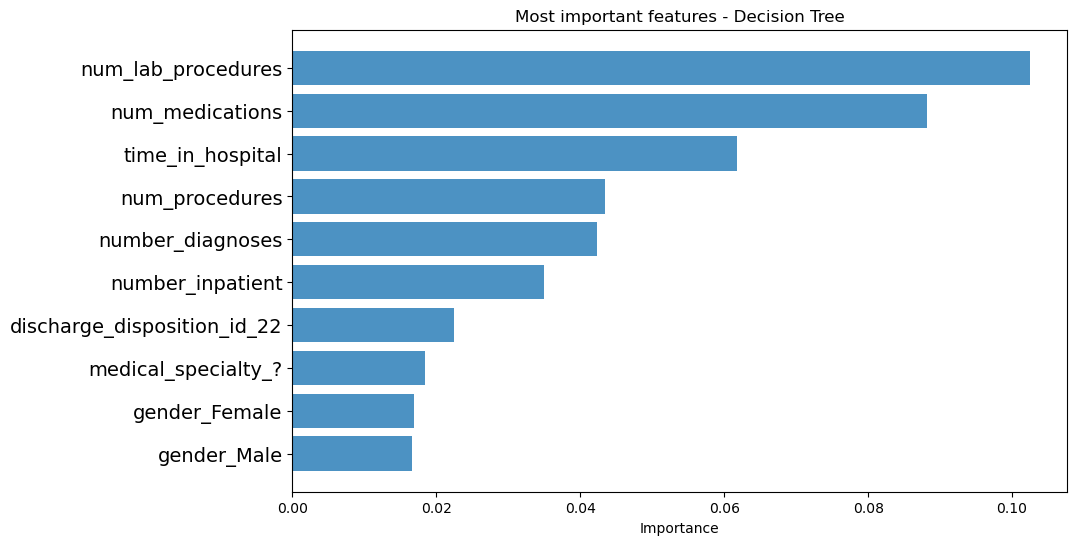

In [59]:

# Create list of top most features based on importance
feature_names = X_train_processed.columns
feature_imports = best_rfc.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
print(most_imp_features)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()

#### 6.1 XGboost

##### 6.1.1 train

In [48]:
# initialize XGBoost classifier
xgc = XGBClassifier(objective="binary:hinge", random_state=2022)

# define the parameter grid to search over
xgc_param_grid = {
    'n_estimators': [500],
    'max_depth': [3,5],
    'learning_rate': [0.1],
    'subsample': [0.5],
    'colsample_bytree': [0.2,0.5],
}

# initialize GridSearchCV with cross-validation
xgc_grid_search = GridSearchCV(xgc, param_grid=xgc_param_grid, cv=5)

# fit the grid search to the training data
xgc_grid_search.fit(X_train_processed, y_train)

# print the best parameters found
print("Best parameters: ", xgc_grid_search.best_params_)

# best estimator parameters
best_xgc = xgc_grid_search.best_estimator_

Best parameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.5}


In [49]:
# evaluate the best model on the training data
training_score = best_xgc.score(X_train_processed, y_train)
print("Training accuracy: {:.3f}".format(training_score))

Training accuracy: 0.910


In [50]:
# evaluate the best model on the training data
X_val_processed = preprocessing_pipeline.transform(X_val)
valdation_score = best_rfc.score(X_val_processed, y_val)
print("Validation accuracy: {:.3f}".format(valdation_score))


GroupICD9IntoCatefories.transform()
Validation accuracy: 0.910


##### 6.1.2 predict

In [54]:
# evaluate the best model on the test data
X_test_preprocessed = preprocessing_pipeline.transform(X_test)
test_score = best_xgc.score(X_test_preprocessed, y_test)
print("Test accuracy: {:.3f}".format(test_score))

GroupICD9IntoCatefories.transform()
Test accuracy: 0.912


<h1 align='center'>Appendix</h1>


`admission_type_id` - admission type - \
    Emergency = 1, \
    Urgent = 2, \
    Elective = 3, \
    Newborn = 4, \
    Not Available = 5, \
    Null = 6, \
    Trauma Center = 7, \
    Not Mapped = 8 \

`discharge_disposition_id`  - Discharge disposition - \
Discharged to home = 1, \
Discharged/transferred to another short term hospital = 2,\
Discharged/transferred to SNF = 3, \
Discharged/transferred to ICF = 4, \
Discharged/transferred to another type of inpatient care institution = 5, \
Discharged/transferred to home with home health service = 6, \
Left AMA = 7, \
Discharged/transferred to home under care of Home IV provider = 8, \
Admitted as an inpatient to this hospital = 9, \
Neonate discharged to another hospital for neonatal aftercare = 10, \
Expired = 11, \
Still patient or expected to return for outpatient services = 12, \
Hospice / home = 13, \
Hospice / medical facility = 14, \
Discharged/transferred within this institution to Medicare approved swing bed = 15, \
Discharged/transferred/referred another institution for outpatient services = 16, \
Discharged/transferred/referred to this institution for outpatient services = 17, \
NULL = 18, \
Expired at home. Medicaid only, hospice. = 19, \
Expired in a medical facility. Medicaid only, hospice. = 20, \
Discharged/transferred to another rehab fac including rehab units of a hospital . = 22, \
Discharged/transferred to a long term care hospital. = 23, \
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare. = 24, \
Not Mapped = 25, \
Unknown/Invalid = 26, \
Discharged/transferred to a federal health care facility. = 27, \
Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital = 28, \
Discharged/transferred to a Critical Access Hospital (CAH). = 29, \
Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere = 30, 

`admission_source_id` - admission source - \
Physician Referral = 1, \
Clinic Referral = 2, \
HMO Referral = 3, \
Transfer from a hospital = 4, \
 Transfer from a Skilled Nursing Facility (SNF) = 5, \
 Transfer from another health care facility = 6, \
 Emergency Room = 7, \
 Court/Law Enforcement = 8, \
 Not Available = 9, \
 Transfer from critial access hospital = 10, \
Normal Delivery = 11, \
 Premature Delivery = 12, \
 Sick Baby = 13, \
 Extramural Birth = 14, \
Not Available = 15, \
NULL = 17, \
 Transfer From Another Home Health Agency = 18, \
Readmission to Same Home Health Agency = 19, \
 Not Mapped = 20, \
Unknown/Invalid = 21, \
 Transfer from hospital inpt/same fac reslt in a sep claim = 22, \
 Born inside this hospital = 23, \
 Born outside this hospital = 24, \
 Transfer from Ambulatory Surgery Center = 25, \
Transfer from Hospice = 26,
 